<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Predict Loan Applicant Behavior with TensorFlow Neural Networking

This notebook guides you through the basic concepts to construct a neural net
model with the
TensorFlow library in Watson Studio. It includes instructions on how to import the predictive
data, train the model to predict
client behaviors, and save the model to use for future inference.

Some familiarity with Python is recommended. This notebook runs on Python 2 with
Spark 2.1.

This TensorFlow neural network tutorial has several aspects that are unique or
not evident in other TensorFlow tutorials, such as the MNIST handwritten digits
tutorial. The focus is on business, both in terms of the use case and data and
in terms of extra steps that are needed to help take your data science results to
production.

## Describe the business problem

This notebook describes how to use the TensorFlow library for a Neural Network
model to predict whether a loan applicant is likely to ‘default’ on a bank loan
based on specific client characteristics. The model must be trained over a
serial of data batches to increase prediction accuracy.

The following characteristics are considered:

   * Predictor variables such as age, education, income.
   * Differing business objectives, for example, curbing the typical defaulters,
or filtering the best applicants only.

To train the machine learning model, a sample data set is provided and run
through in this notebook that specifies the data and
variables.

## Table of Contents

1. [Import the Data](#import)<br>
2. [Download the TensorFlow library](#download)<br>
3. [Tuning the Hyperparameters](#tuning)<br>
4. [Save the Model](#save-model)<br>
5. [Derive Confidence Values](#derive)<br>
6. [Summary](#summary)<br>
    a. [Related Links](#rel_links)<br>
    b. [Author information](#author)<br>

<div class="alert alert-block alert-info">
You can follow along if you already installed
Jupyter, Python and TensorFlow, or you can take a few minutes to sign up for a free
trial of IBM Watson Studio on IBM Cloud to run the notebook on a data science
platform <a href="https://datascience.ibm.com/" target="_blank">here</a>.
</div>

<a id="import"></a>
## Import the Data

As a prerequisite, you must prepare a CSV file that you would like to use the
TensorFlow neural net with.

To provide an example, a sample data file that is called `bankloanData.csv` from the IBM SPSS Statistics package is extracted and is available for download here: <a href="https://github.com/john-boyer-phd/TensorFlow-Samples/tree/master/Neural%20Net" target="_blank">John Boyer's GitHub repo</a>. The advantages are that theresulting TensorFlow code can be easily adapted to build bigger neural nets that can learn from much larger data sets.

This particular sample is selected because it is easy to use SPSS to double
check whether the TensorFlow code is behaving as expected (for more
information on IBM SPSS, see [Related Links](#rel-links)).

The dependent variable is called the ‘label’, and the data in the column is
called the ‘labeled data’. In this case, the dependent variable that is
predicted is the column that is named ‘default’ in the CSV file.

To read the CSV file from cloud Object Storage into a Pandas Dataframe, open the
**Files** window by clicking the binary icon in the upper right corner and
upload the file. Then, select the empty cell below and click Insert to code, and
then Insert Pandas DataFrame. After the code is
loaded, the cell can be run to read the CSV file.

For larger data sets, you can prefer to use a SparkSession Dataframe instead, but
in that case, you’ll need to slightly adjust the numpy extraction code in the
next notebook cell.

In [1]:
# @hidden_cell
# USE 'INSERT CODE' HERE
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.

# Please change last two lines to 'df_data_1...' rather than 'df_data_2...' etc.

,﻿age,ed,employ,address,income,debtinc,creddebt,othdebt,default,preddef1,preddef2,preddef3
0,41,3,17,12,176,9.3,11.359392,5.008608,1,0.808394,0.788640,0.213043
1,27,1,10,6,31,17.3,1.362202,4.000798,0,0.198297,0.128445,0.436903
2,40,1,15,14,55,5.5,0.856075,2.168925,0,0.010036,0.002987,0.141023
3,41,1,15,14,120,2.9,2.658720,0.821280,0,0.022138,0.010273,0.104422
4,24,2,2,0,28,17.3,1.787436,3.056564,1,0.781588,0.737885,0.436903


As you can see from the chart that is generated, the predictor variables are as follows:

- *age*
- *ed* (level of education)
- *employ*
- *address* (years at current address)
- *income* (household income in thousands)
- *debtinc*
- *creddebt*
- *othdebt* (other debt in thousands)

The predictor variables are also called ‘features’. The remaining columns of
data are unnecessary for this particular model.

Now, look at the details of the data columns.

If the following code cells generate an error message, please recitify the last two lines of the previous import code to 
<br><br>
*df_data_1 = pd.read_csv(body)<br>
df_data_1.head()*

In [2]:
df_data_1.dtypes

﻿age          int64
ed            int64
employ        int64
address       int64
income        int64
debtinc     float64
creddebt    float64
othdebt     float64
default      object
preddef1    float64
preddef2    float64
preddef3    float64
dtype: object

In [3]:
df_data_1.values

array([[41, 3, 17, ..., 0.808394327359702, 0.7886404318214371,
        0.21304337612811897],
       [27, 1, 10, ..., 0.19829747615910395, 0.128445387038174,
        0.43690300550604605],
       [40, 1, 15, ..., 0.0100361080990023, 0.00298677834821412,
        0.141022623460993],
       ..., 
       [48, 1, 13, ..., 0.0301374981044824, 0.0325702625943738,
        0.24801041775523303],
       [35, 2, 1, ..., 0.26900345101699397, 0.37854649636973203,
        0.181814378077261],
       [37, 1, 20, ..., 0.006397812918809229, 0.0111731232851226,
        0.30304155578236497]], dtype=object)

The next couple of cells prunes the data. The code assumes that a
Pandas dataframe that are named `df_data_1` exists and uses it to extract the data into
numpy arrays that are needed as input to the TensorFlow API. The comprehension in the
first np.array() removes instances (rows) that are missing a label.

In [4]:
import numpy as np

# Make a numpy array from the dataframe, except remove rows with no value for 'default'
i = list(df_data_1.columns.values).index('default')
data = np.array([x for x in df_data_1.values if x[i] in ['0', '1']])

# Remove the columns for preddef1, predef2 and preddef3
data = np.delete(data, slice(9,12), axis=1)

# Separate the 'predictors' (aka 'features') from the dependent variable (aka 'label') 
# that we will learn how to predict
predictors = np.delete(data, 8, axis=1)
dependent = np.delete(data, slice(0, 8), axis=1)

The next cell reshapes the data slightly, with the following steps:

1. Separate predictors from the dependent variable.
2. Convert labeled data from type string to type integer.
3. Flatten the dependent array to one dimension to match the shape of the data
that comes from the neural network output layer.
4. Convert the predictor type to Float to facilitate matrix multiplication with
weights and biases within the neural network.

In [5]:
# Convert the label type to numeric categorical representing the classes to predict (binary classfier)
dependent = dependent.astype(int)

# And flatten it to one dimensional for use as the expected output label vector in TensorFlow
dependent = dependent.flatten()
dependent

# Convert all the predictors to float to simplify this demo TensorFlow code
predictors = predictors.astype(float)

# Get the shape of the predictors
m, n = predictors.shape
m, n

(700, 8)

In [6]:
# Take a peak at the first sample of the predictors
predictors[0]

array([  41.      ,    3.      ,   17.      ,   12.      ,  176.      ,
          9.3     ,   11.359392,    5.008608])

In [7]:
# Take a peak at the dependent variable values
dependent

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1,

When you train the model, the feature values of the instances (rows) of data are
input to the neural net, and the weights and biases of the neural network are
adjusted to minimize ‘loss’, which coarsely maps to maximizing accuracy of the
neural network’s output layer predictions of the labeled data.

<a id="random"></a>
### Randomize the training data

The next cell takes the first 500 instances as training data, and leaves the
remaining 200 instances as a test set. This particular sample is already
randomly enumerated, so there is no need to randomly select the training and
test sets from the data. The code also chooses about a 70:30 percent split
for training and testing. Though, it does not round the split sample to a size
divisible by the training batch size, which is defined later in the notebook.

This cell also defines a method that returns batch-sized slices of the training
data. If the training data is too large to fit in memory, then this method can
instead load data one batch at a time, such as with an SQL query.

In [8]:
# Partition the input data into a training set and a test set

m_train = 500
m_test = m - m_train

predictors_train = predictors[:m_train]
dependent_train = dependent[:m_train]

predictors_test = predictors[m_train:]
dependent_test = dependent[m_train:]

# Gets a batch of the training data. 
# NOTE: Rather than loading a whole large data set as above and then taking array slices as done here, 
#       This method can connect to a data source and select just the batch needed.
def get_training_batch(batch_num, batch_size):
    lower = batch_num * (m_train // batch_size)
    upper = lower + batch_size
    return predictors_train[lower:upper], dependent_train[lower:upper]

<a id="download"></a>
## Download the TensorFlow library

Now you are set to start the training with some actual TensorFlow code. The next
cell imports the TensorFlow library and makes a few initializations. After, it
defines a method that will build a neural network layer of any size, connect it
to a preceding layer, and set the output activation function.

In [9]:
import tensorflow as tf

# Make this notebook's output stable across runs
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

# A method to build a new neural net layer of a given size,  
# fully connect it to a given preceding layer X, and 
# compute its output Z either with or without (default) an activation function
# Call with activation=tf.nn.relu or tf.nn.sigmoid or tf.nn.tanh, for examples

def make_nn_layer(layer_name, layer_size, X, activation=None):
    with tf.name_scope(layer_name):
        X_size = int(X.get_shape()[1])
        SD = 2 / np.sqrt(X_size)
        weights = tf.truncated_normal((X_size, layer_size), dtype=tf.float64, stddev=SD)
        W = tf.Variable(weights, name='weights')
        b = tf.Variable(tf.zeros([layer_size], dtype=tf.float64), name='biases')
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

The next section is where most of the tuning of hyperparameters occurs.

<a id="tuning"></a>
## Tuning network structure and activation function

Now you can add the code cell that builds the neural network structure. In this
case, you have one input layer `X`, one hidden layer `hidden1`, and one output
layer `outputs`. The comments in the following code cell explain how to add more
hidden layers, but with this sample data, it is possible to learn everything
with only one layer. The output layer has two nodes, one for outputting class 0
(the loan applicant will not default) and the other for class 1 (the loan applicant
will default). The `y` variable will be used during tis usedtore the
labeled data that is expected to match with the output layer.

One line of code that helps makes this tutorial unique is the one that creates a
tf.identity() node that gives the name `nn_output`. This allows you to save a
name for the output layer so that you can recover and use the output layer after
a restore.

In [10]:
# Make the neural net structure

n_inputs = n
n_hidden1 = n 
### n_hidden2 = n // 2
n_outputs = 2   # Two output classes: defaulting or non-defaulting on loan

X = tf.placeholder(tf.float64, shape=(None, n_inputs), name='X')

with tf.name_scope('nn'):
    hidden1 = make_nn_layer('hidden1', n_hidden1, X, activation=tf.nn.relu)
    hidden2 = hidden1
    ### hidden2 = make_nn_layer('hidden2', n_hidden2, hidden1, activation=tf.nn.relu)
    outputs = make_nn_layer('outputs', n_outputs, hidden2) 
    outputs = tf.identity(outputs, "nn_output")
    
y = tf.placeholder(tf.int64, shape=(None), name='y')

The input parameters that are passed to a neural network during inference are the feature
values. During training, the input parameters are feature values and the
expected output are labeled data. But the neural network is adaptable beyond
previously mentioned input parameters, and these configurable parts are called
hyperparameters. The hyperparameters contain the number and size of the hidden
layers and the activation function.  You can try other numbers and sizes of
hidden layers. ‘tanh’ and ‘sigmoid’ are other activation functions that you can try.
However, the default configuration works best on this data.

What you accomplished so far in this notebook is create the main part of a
TensorFlow compute graph that has the shape for a neural network. Next,
you must attach two different root nodes to the output layer, one that adds
functions for training and the other for testing, like in the following
cell. The ‘training_op’ uses the gradient descent method for minimizing loss (of
perfect confidence in the correct answers and zero confidence in incorrect
answers, where the correct answers are provided by the labeled data that are
in ‘y’).

In [11]:
# Define how the neural net will learn

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs)
    loss = tf.reduce_mean(xentropy, name='l')
    
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("test"):
    correct = tf.nn.in_top_k(tf.cast(outputs, tf.float32), y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

<a id="save-dir"></a>
### Create save directories

Now you must run this cell that sets up your ability to save the model when it
is trained. You need to do these mkdir commands the first time that you run
this notebook only, so you might want to put them in a separate cell to make it
easier to skip them. 

In [12]:
# Set up the ability to save and restore the trained neural net...

init = tf.global_variables_initializer()
saver = tf.train.Saver()

<a id="save"></a>
## Train the Data

Now you can run the magic notebook cell that trains and saves the trained model.
Each epoch of training exposes the neural net to the entire set of training
data. When you run the code, you can see the accuracy of results increase over
the many epochs of runs, just as biological neural networks learn through
repetition. For each epoch, you run through the training data in batches to
simulate how you’d handle a larger training set. Each batch of features and
corresponding labeled data is fed to the `training_op` root node in the compute
graph, which is run by *training_session.run()*.

One aspect of this tutorial that is unique (relative to other tutorials) is the
randomization of the training data that takes place at the beginning of each
epoch.  This essentially drives different data into the batches in each epoch,
which dramatically improves accuracy over a larger number of epochs (though it
is much easier programmatically to do this randomization when all data fits into
memory).

In [14]:
# TRAINING TIME

# This is how many times to use the full set of training data
n_epochs = 3000

# For a larger training set, it's typically necessary to break training into
# batches so only the memory needed to store one batch of training data is used
batch_size = 50

with tf.Session() as training_session:
    init.run()
    
    for epoch in range(n_epochs):
        
        # Shuffling (across batches) is easier to do for small data sets and
        # helps increase accuracy
        training_set = [[pt_elem, dependent_train[i]] for i, pt_elem in enumerate(predictors_train)]
        np.random.shuffle(training_set)
        predictors_train = [ts_elem[0] for ts_elem in training_set]
        dependent_train = [ts_elem[1] for ts_elem in training_set]
        
        # Loop through the whole training set in batches
        for batch_num in range(m_train // batch_size):
            X_batch, y_batch = get_training_batch(batch_num, batch_size)
            training_session.run(training_op, feed_dict={X: X_batch, y: y_batch})

        if epoch % 100 == 99:
            acc_train = accuracy.eval(feed_dict={X: predictors_train, y: dependent_train})
            acc_test = accuracy.eval(feed_dict={X: predictors_test, y: dependent_test})
            print(epoch+1, "Training accuracy:", acc_train, "Testing accuracy:", acc_test)

    save_path = saver.save(training_session, "../datasets/Neural Net/Neural Net.ckpt")
    
    # A quick test with the trained model 
    Z = outputs.eval(feed_dict={X: predictors_test[:20]})
    dependent_pred = np.argmax(Z, axis=1)
    print("")
    print("Actual classes:   ", dependent_test[:20])  
    print("Predicted classes:", dependent_pred)

(100, 'Training accuracy:', 0.75999999, 'Testing accuracy:', 0.755)
(200, 'Training accuracy:', 0.77399999, 'Testing accuracy:', 0.79000002)
(300, 'Training accuracy:', 0.79799998, 'Testing accuracy:', 0.81999999)
(400, 'Training accuracy:', 0.79799998, 'Testing accuracy:', 0.83499998)
(500, 'Training accuracy:', 0.80800003, 'Testing accuracy:', 0.82499999)
(600, 'Training accuracy:', 0.796, 'Testing accuracy:', 0.815)
(700, 'Training accuracy:', 0.80199999, 'Testing accuracy:', 0.81)
(800, 'Training accuracy:', 0.78799999, 'Testing accuracy:', 0.815)
(900, 'Training accuracy:', 0.81, 'Testing accuracy:', 0.815)
(1000, 'Training accuracy:', 0.81999999, 'Testing accuracy:', 0.81)
(1100, 'Training accuracy:', 0.81800002, 'Testing accuracy:', 0.81)
(1200, 'Training accuracy:', 0.80599999, 'Testing accuracy:', 0.80500001)
(1300, 'Training accuracy:', 0.80199999, 'Testing accuracy:', 0.815)
(1400, 'Training accuracy:', 0.81199998, 'Testing accuracy:', 0.81999999)
(1500, 'Training accuracy:'

<div class="alert alert-block alert-warning"><b>Author's Sidebar:</b>
When you do business with a real stakeholder customer, you need to have a second
test set, often called a validation set or a blind set. Why do you need a second
test set? The typical reply might be akin to, “I don’t know, to
double-check accuracy?”  Well, that is not incorrect. But if you look at the structure of
training, the weights and biases are affected not just by the training data.
Indirectly, they are also affected by the test data because you choose
<i>n_epochs</i> to keep running training epochs until you get the best accuracy
on the test set. In other words, you're teaching to the test. The validation set
or blind set has no such indirect effect on the weights and biases that are computed for
the neural network. It is another test set that to ensure construct
validity, must be randomly from the same pool of data that the training set
and test set are randomly selected from. In this way, the validation set is not
just the ‘final exam’, it’s the first experience of the real world.
</div>

<a id="save-model"></a>
## Save and Restore models for a Production Environment

When all training is done, the model is saved into the data sets subdirectory that is created previously. For larger training data sets, you can call on
TensorFlow to save on checkpoints throughout the epoch-based training so that
you can stop and resume training if needed. The list of the model files is
generated by the following code.

In [15]:
# List the model files
!ls -l "../datasets/Neural Net"

total 0
-rw------- 1 s646-4d27fbe1c5e9eb-6e7f59c73e81 users    87 Feb 21 14:02 checkpoint
-rw------- 1 s646-4d27fbe1c5e9eb-6e7f59c73e81 users   720 Feb 21 14:02 Neural Net.ckpt.data-00000-of-00001
-rw------- 1 s646-4d27fbe1c5e9eb-6e7f59c73e81 users   238 Feb 21 14:02 Neural Net.ckpt.index
-rw------- 1 s646-4d27fbe1c5e9eb-6e7f59c73e81 users 25750 Feb 21 14:02 Neural Net.ckpt.meta


The data files that TensorFlow created during that save operation can be
transported to a production environment. The neural network can then be restored
by using the code in the next cell, and the input and output layers can be obtained
and used for inference, by using *get_tensor_by_name()*.

The next cell also shows how to reference into the hierarchy of a name scope to get the output layer from within the neural network structure. It mocks
up by having a REST API receive a batch of feature instances and converting them
to a numpy array by taking a slice of the test data.  With the inference
TensorFlow session, the compute graph and the values it contained are restored.
After that, you obtain the tensors corresponding to the neural network input and output
layers by using the names that you previously assigned.  Then, you run the output
layer, and give the batch of feature instances to the input layer `X`
(*inference_session.run()*). The predictions of the dependent variable are then
obtained by choosing whichever of the two output layer nodes that have the higher
value (by using *np.argmax()*).

In [16]:
# Restore the saved model and use it to perform inference on a "received" new set of data

# We will simulate "receiving" the new data by taking some slice of the test set (all in this case).
predictors_received = predictors_test[:]

import tensorflow as tf_inference

with tf_inference.Session() as inference_session:
    inf_saver = tf_inference.train.import_meta_graph('../datasets/Neural Net/Neural Net.ckpt.meta')
    inf_saver.restore(inference_session, tf_inference.train.latest_checkpoint('../datasets/Neural Net/'))
    
    graph = tf_inference.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    nn_output = graph.get_tensor_by_name("nn/nn_output:0")

    Z = inference_session.run(nn_output, feed_dict={X: predictors_received})
    dependent_pred = np.argmax(Z, axis=1)
    
print("Actual classes:   ", dependent_test[20:40])
print("Predicted classes:", dependent_pred[20:40])

INFO:tensorflow:Restoring parameters from ../datasets/Neural Net/Neural Net.ckpt
('Actual classes:   ', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]))
('Predicted classes:', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]))


### Transfer learning

As another unique aspect of this tutorial, you can also use this
method of naming with <i>tf.identity</i> and then getting the tensor from a
restored graph to transfer learning between neural nets. Specifically, when you
create a hidden layer with <i>make_nn_layer()</i>, you can name it with
<i>tf.identity</i>. Then, you train and save as shown above. To transfer to a
second neural net, you restore the trained and saved one, get the hidden layer
by name, attach alternative fully connected hidden layers as needed, and an
alternative output layer, and then train the new second neural network by using the method above.

<a id="derive"></a>
## Derive confidence values for neural net output

Finally, to showcase more feature that makes this tutorial unique, you can look
at how to get the actual confidence values for the predictions. This might not
seem as important when you do the MNIST hand-written digit tutorial, but
in a business context it’s important to know how much confidence we have in an
answer.

In [17]:
with tf_inference.Session() as inference_session:
    inf_saver = tf_inference.train.import_meta_graph('../datasets/Neural Net/Neural Net.ckpt.meta')
    inf_saver.restore(inference_session, tf_inference.train.latest_checkpoint('../datasets/Neural Net/'))
    
    graph = tf_inference.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    nn_output = graph.get_tensor_by_name("nn/nn_output:0")

    dependent_prob = inference_session.run(tf_inference.nn.softmax(nn_output), feed_dict={X: predictors_received})

confidences = [p[dependent_pred[i]] for i, p in enumerate(dependent_prob)]
    
print("Confidences: ", confidences[20:40])
print("")
print("Probabilities: ", dependent_prob[20:40])

INFO:tensorflow:Restoring parameters from ../datasets/Neural Net/Neural Net.ckpt
('Confidences: ', [0.72115788841227291, 0.80607047578305713, 0.83934041973914708, 0.99522251895376912, 0.63583707224033514, 0.92301370061024191, 0.9246727235093638, 0.78439759502501394, 0.99999999999583422, 0.64561868763996899, 0.72736408931601482, 0.64561868763996899, 0.83959328566375235, 0.94291801514712859, 0.68170960394665236, 0.99981345698850999, 0.96778595641239318, 0.59248611260528017, 0.99293831799558985, 0.5220483545876663])

('Probabilities: ', array([[  7.21157888e-01,   2.78842112e-01],
       [  8.06070476e-01,   1.93929524e-01],
       [  8.39340420e-01,   1.60659580e-01],
       [  9.95222519e-01,   4.77748105e-03],
       [  6.35837072e-01,   3.64162928e-01],
       [  9.23013701e-01,   7.69862994e-02],
       [  9.24672724e-01,   7.53272765e-02],
       [  7.84397595e-01,   2.15602405e-01],
       [  1.00000000e+00,   4.16586334e-12],
       [  3.54381312e-01,   6.45618688e-01],
       [  

To get the confidence values, a new root node was inserted onto the output layer
to apply the *softmax* function. Now the compute graph produces the probability
of occurrence for each output value. Then, one final comprehension was done to
ferret out the confidences of the predicted labels for each feature instance.

In [18]:
# Now we're going to assess the quality of the neural net using ROC curve and AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# send the actual dependent variable classifications for param 1, 
# and the confidences of the true classification for param 2.
FPR, TPR, _ = roc_curve(dependent_test, dependent_prob[:, 1])

# Calculate the area under the confidence ROC curve.
# This area is equated with the probability that the classifier will rank 
# a randomly selected defaulter higher than a randomly selected non-defaulter.
AUC = auc(FPR, TPR)

# What is "good" can dependm but an AUC of 0.7+ is generally regarded as good, 
# and 0.8+ is generally regarded as being excellent 
AUC

0.85273972602739712

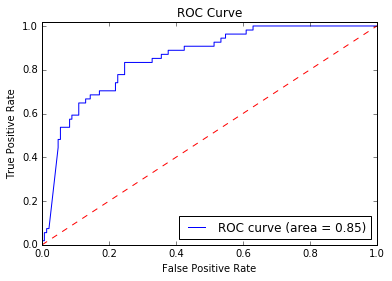

In [19]:
# Now we'll plot the confidence ROC curve 
plt.figure()
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

You can also run a classification report to see how the model is behaving within
each class.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(dependent_test, dependent_pred))

             precision    recall  f1-score   support

          0       0.86      0.91      0.88       146
          1       0.71      0.59      0.65        54

avg / total       0.82      0.82      0.82       200



As you can see, the recall on non-defaulters is 91%, which means the model
allows most non-defaulters proceed to getting a loan. The recall for defaulters
is only 59%, so many defaulters are flagged, but a substantial number are not.

If the business objective of the model is to curb many but not all of the deficient
applications while not perturbing business for better customers, then this is a good model.  But suppose that the objective is to have a model that lets through
only the best applications and flags the rest for review. It might be costly to
review many applications, but that cost might be less than the cost of making
considerable loans that don't get repaid.

To accommodate for the different objectives, this notebook calculates the
confidence threshold that it would take to get a perfect true positive rate (that is, to
detect all of the defaulters in the test set) even if that means you also get many false positives (that is, non-defaulters that the model classifies as
defaulters).  If you look up at the ROC curve, you can see that a perfect 100%
TPR happens just above 60% FPR, so the overall accuracy will be lower due to the number of false positives, but the
confidence threshold is better from the standpoint of achieving the alternative desired business objective.

In [21]:
# Say you want a model that is very accurate at recalling true positives (defaulters), 
# even if it gets a lot a false positives (non-defaulters). You might be automatically
# accepting the false classifications and, for true classifications, you may send them
# for human review rather than rejecting their loan applications.

# The lowest confidence that can give 100% TPR on the test set is equal to the 
# true class with the lowest confidence, so we'll find that now
defaulter_probs = [dependent_prob[i][1] for i, p in enumerate(dependent_test) if p == 1]
min_conf = np.min(defaulter_probs)
min_conf

0.043730491447763684

In [22]:
# Each non-defaulter with a confidence at or above min_conf would be predicted 
# to be a defaulter (which would be a false positve prediction for a non-defaulter)

non_defaulter_probs = [dependent_prob[i][1] for i, p in enumerate(dependent_test) if p == 0]
false_positives = [x for x in non_defaulter_probs if x >= min_conf]

total = len(defaulter_probs) + len(non_defaulter_probs)
total_correct = total - len(false_positives)
accuracy = float(total_correct) / total

# Overall accuracy would suffer quite a bit, but this achieves 
# the desired high accuracy on true positive identification (defaulters)  
accuracy

0.54

In [23]:
## For when you want to wipe out the training and do it again
# !rm -rf "../datasets/Neural Net"
## !rm -rf "../datasets"

<a id="summary"></a>
## Summary

You learned how to import the TensorFlow library from IBM Watson Studio, create
a neural network with layers, train the model to accurately predict business
behavior to achieve your business objective.

<a id="rel_links"></a>
## Related Links

1. <a href="https://datascience.ibm.com/" target="_blank">See Watson Studio</a>
2. <a href="https://www.ibm.com/developerworks/community/profiles/html/profileView.do?userid=060000VMNY&lang=en" target="_blank">Author's Blog on IBM Developer Works</a>
3. <a href="https://www.ibm.com/developerworks/community/blogs/JohnBoyer/entry/Measuring_the_Quality_of_a_TensorFlow_Neural_Network_An_IBM_Data_Science_Experience?lang=en" target="_blank">Author Blog: Measuring the Quality of a TensorFlow Neural Network</a>
4. <a href="https://www.ibm.com/ca-en/marketplace/spss-statistics" target="_blank">IBM SPSS Statistics</a>


<a id="author"></a>
### Author

John M. Boyer, IBM Global Chief Data Office

<hr>
Copyright © IBM Corp. 2018. This notebook and its source code are released under
the terms of the MIT License.